Introduction
------------

In this demo, we will focus on CF ensemble learning methods by directly predicting the reliability of each probability score from the base classifiers (users) in both `R` and `T` without needing to first guesstimating the labels of the test set (T). 

Specicially, given `T` (rating matrix of the test set) for which we wish to predict its corresponding class labels, we will break down this predictive task into the following subproblems: 

1. Predict reliability of `T`; that is, predict T's probability filter (reliability matrix) where 0s represent unreilable entries (e.g., FPs and FNs) and 1s represent reliable entries (e.g., TPs and TNs)
  - The reliability of `R` is known since we know the (true) labels for the training set. 

2. Run a chosen collaborative filtering algorithm to reestimate the rating matrix combining the ratings from the training set (`R`) and those from the test set (`T`)
  - Recall from **Demo Part 1 and 2** that the purpose of probaiblity filter is to help us select the entries of R and T that will enter the optimization objective (see Part 2) while the remaining entries get left out; that is, we wish to find the latent factors for users (classifiers) and items (data) such that they approximate either the rating (probability score) or the label well. 
  - Reliable entries should enter the optimization objectve while unreliable entries are typically left out (unless your loss function somehow can take into account of these entries, see C-square loss for an example)

3. Once we get `Th` (the re-estimated `T`), we will then combine their ratings to formulate our final class label predictions as usual (e.g., mean, majority vote, stacking)

In [1]:
#@title Import Basic Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import os, sys

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
# %matplotlib inline

from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

# Progress
from tqdm import tqdm

################################################################
# Configure system environment
# - Please modify input_dir according to your local enviornment
#
################################################################

cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble']


In [2]:
#@title Import Tensorflow and CF-Related Libraries
import tensorflow as tf
print(tf.__version__)
# import tensorflow_probability as tfp
# tfd = tfp.distributions
from tensorflow import keras

# from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
#################################################################

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#################################################################

# CF-ensemble-specific libraries
import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as usys
import utils_cf as uc 
import polarity_models as pmodel
from polarity_models import Polarity
import scipy.sparse as sparse
from utils_sys import highlight
#################################################################

# Misc
import pprint
import tempfile
from typing import Dict, Text

np.set_printoptions(precision=3, edgeitems=5, suppress=True)

2.8.0


In [3]:
#@title Generate Training Data
import data_pipeline as dp

max_class_ratio=0.99

# get the dataset
X0, y0 = dp.generate_imbalanced_data(class_ratio=max_class_ratio, verbose=1)

> n_classes: 2
[0 1]

> counts:
Counter({0: 4465, 1: 535})



In [4]:
#@title Define and Choose Base Classifiers
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y0))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

In [5]:
#@title Generate Rating Matrices
import cf_models as cm

tLoadPretrained = True
######################
fold_number = 0
n_iterations = 1
data_dir = os.path.join(input_dir, 'data')
######################

if not tLoadPretrained:  
    # Use the previously selected base predictors (`base_learners`) to generate the level-1 dataset
    R, T, U, L_train, L_test = cm.demo_cf_stacking(input_data=(X0, y0), 
                                                   input_dir=input_dir, n_iter=n_iterations, 
                                                   base_learners=base_learners, # <<< base classifiers selected
                                                   verbose=1)
else: 
    R, T, U, L_train, L_test = dp.load_pretrained_level1_data(fold_number=fold_number, verbose=1, data_dir=data_dir)

# Derived quantities
n_train = R.shape[1]
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax')
lh = uc.estimateLabels(T, p_th=p_threshold) # We cannot use L_test (cheating), but we have to guesstimate
L = np.hstack((L_train, lh)) 
X = np.hstack((R, T))

assert len(U) == X.shape[0]
print(f"> shape(R):{R.shape} || shape(T): {T.shape} => shape(X): {X.shape}")

2.8.0
[info] list of base classifiers:
['RF' 'KNNC' 'GNB' 'QDA' 'MLPClassifier']

[info] probability thresholds:
[0.499 0.    0.008 0.    0.031]

> shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)


In [6]:
#@title Confidence Matrix
# import utils_cf as uc
# import polarity_models as pmodel

# n_factors = 100
alpha = 100.0 
conf_measure = 'brier' # Options: 'brier', 'uniform'
policy_threshold = 'fmax'

# Training matrices
CX = uc.evalConfidenceMatrix(R, L=L_train, U=U, 
                                 p_threshold=p_threshold, # Optional: Not needed if L is given (suggested use: estimate L outside of this call)
                                 policy_threshold=policy_threshold,
                                 conf_measure=conf_measure, 
                                 fill=0, is_cascade=False,
                                 fold=fold_number, 
                                 verbose=0) 
C0, Pc, p_threshold, *CX_res = CX

assert C0.shape == R.shape
y_colors = pmodel.verify_colors(Pc)  # [log] status: ok

# Test matrices 
CY = uc.evalConfidenceMatrix(T, L=lh, U=U, 
                                 p_threshold=p_threshold, # Optional: Not needed if L is given (suggested use: estimate L outside of this call)
                                 policy_threshold=policy_threshold,
                                 conf_measure=conf_measure, 
                                 fill=0, is_cascade=False,
                                 fold=fold_number, 
                                 verbose=0) 
C0_test, Pc_test, _, *_ = CY

assert C0_test.shape == T.shape
y_colors_test = pmodel.verify_colors(Pc_test)  # [log] status: ok



### Using Seq2seq as the polarity model [todo]

In [7]:
assert Pc.shape == R.shape
include_label = True # include class labels as part of the training data?

P = uc.to_preference(Pc) # color matrix to probability filter (where {TP, TN} maps to 1 and {FP, FN} maps to 0)
X_train, Y_train = pmodel.make_seq2seq_training_data(R, Po=P, L=L_train, include_label=include_label, verbose=1)

print(f"> shape(R): {R.shape}")
print(f"> shape(X_train): {X_train.shape}, shape(Y_train): {Y_train.shape}")

P_test = uc.to_preference(Pc_test)
# lh_max_vote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)
X_test, Y_test = pmodel.make_seq2seq_training_data(T, Po=P_test, L=lh, include_label=include_label, verbose=1)

print(f"> shape(T): {T.shape}")
print(f"> shape(X_test): {X_test.shape}, shape(Y_test): {Y_test.shape}")



[info] shape(X): (3750, 6, 1), shape(Y): (3750, 6, 1)
> shape(R): (5, 3750)
> shape(X_train): (3750, 6, 1), shape(Y_train): (3750, 6, 1)
[info] shape(X): (1250, 6, 1), shape(Y): (1250, 6, 1)
> shape(T): (5, 1250)
> shape(X_test): (1250, 6, 1), shape(Y_test): (1250, 6, 1)


In [8]:
i = np.random.choice(range(R.shape[1]), 1)[0]
print(X_train[i])
print(Y_train[i])


[[0.5  ]
 [0.   ]
 [0.114]
 [0.   ]
 [0.003]
 [0.   ]]
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [9]:
import seq2seq as smodel

epochs = 300

n_users = R.shape[0]

loss_fn = bce = tf.keras.losses.BinaryCrossentropy()
model_seq = smodel.get_stacked_lstm(n_users if not include_label else n_users+1, # n_users + 1 to include the class labels in the last row
                                    n_features=1, 
                                    n_units=n_users*2, 
                                    loss=loss_fn, activation='sigmoid', verbose=1)

history = smodel.train_test(model_seq, X_train, Y_train, X_test, Y_test, epochs=epochs, verbose=1)

model_seq.evaluate(X_test)

Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 6, 10),      480         ['input_1[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 lstm_1 (LSTM)                  (None, 6, 10)        840         ['lstm[0][0]',                   
                                                                

[0.0, 0.0]

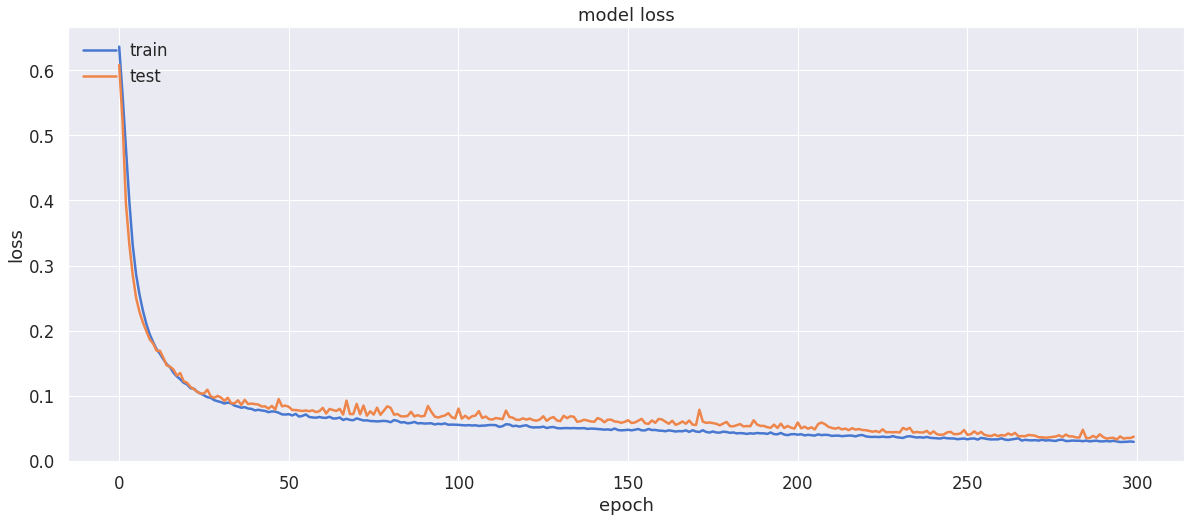

In [10]:
%matplotlib inline
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [11]:
Y_test_est = model_seq.predict(Y_test) 
Y_train_est = model_seq.predict(Y_train) # Although we already know the reliability matrix for the training set, ... 
# ... we will need this "continuous representation" (instead of a 0-1 encoded matrix) to infer reliability thresholds
print(f"> shape(Y_pred): {Y_test_est.shape}") # (1250, 5, 1): n_samples x n_users x n_features

i = np.random.choice(range(T.shape[1]), 1)[0]
print(f"> T[:, {i}]:\n{T[:, i].reshape(-1, 1)}\n=> Y_pred[{i}]:\n{Y_test_est[i]}\n")

> shape(Y_pred): (1250, 6, 1)
> T[:, 566]:
[[0.499]
 [0.   ]
 [0.124]
 [0.089]
 [0.14 ]]
=> Y_pred[566]:
[[0.999]
 [1.   ]
 [0.999]
 [0.999]
 [1.   ]
 [1.   ]]



In [12]:
test_ids = np.random.choice(range(T.shape[1]), 3)
Y_test_est[test_ids, :, :]

array([[[0.   ],
        [0.   ],
        [0.45 ],
        [0.   ],
        [0.   ],
        [0.   ]],

       [[0.999],
        [1.   ],
        [0.999],
        [0.999],
        [1.   ],
        [1.   ]],

       [[0.   ],
        [0.   ],
        [0.45 ],
        [0.   ],
        [0.   ],
        [0.   ]]], dtype=float32)

In [13]:
# CF parameters
alpha = 100.0

n_users = R.shape[0]
n_test, n_seq_len, n_features = Y_test_est.shape

In [14]:
# Combine probability filter from the training set (P) and the predicted filter from test set (Ph)
P_test = Y_test_est.squeeze().T
P_train = Y_train_est.squeeze().T
print(f"> shape(P_test): {P_test.shape}, shape(P_train): {P_train.shape}")

lh_max_vote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)
lh_seq2seq = lh_max_vote
acc_seq2seq = np.nan
if include_label: 
    # if so, then the last row of P_train and P_test are the class labels (for the test split, the class labels are really the "predicted" labels)
    print("> `include_label` set to True => last row holds the (true) class labels for R and estimated labels for T ...")
    lh_seq2seq = P_test[n_users] # the last row is the predicted label

    # Convert reliabliity scores to class labels
    # ret = uc.classPrior(L_train, labels=[0, 1], ratio_ref=0.1, verbose=False)
    r_th = P_train[n_users][L_train == 1].min()
    lh_seq2seq = np.where(lh_seq2seq >= r_th, 1, 0)
    print(f"> reliablity threshold for class label in training set: {r_th}")

    P_train = P_train[:n_users, :]
    P_test = P_test[:n_users, :]
    acc_seq2seq = np.sum(lh_seq2seq == L_test) / (len(L_test)+0.0)

assert P_test.shape == T.shape
assert P_train.shape == R.shape

# Convert soft filter to a "hard" filter 
# Method 1: Use soft filter from training set to infer reliability threshold, from which to infer the test set filter
Pf_seq2seq, r_th = pmodel.infer_probability_filter(X=(R, T), 
                                                   L=L_train, 
                                                   P=(P_train, P_test),
                                                   p_th=p_threshold, verbose=1) # `r_th`: reliability threshold 

n_reliable = (Pf_seq2seq == 1).sum()
n_unreliable = (Pf_seq2seq == 0).sum()
assert n_reliable + n_unreliable == Pf_seq2seq.size
print(f"[info] n_reliable: {n_reliable}, n_unreliable: {n_unreliable}")
print(f"       r_reliable: {n_reliable/Pf_seq2seq.size}, r_unreliable: {n_unreliable/Pf_seq2seq.size}")

# Method 2: Mix hard filter from training set and soft filter from the test set
# P_train, Lh = pmodel.probability_filter(R, L_train, p_threshold)
# P_seq2seq = np.hstack([P_train, P_test])

C = uc.balance_and_scale_given_reliability_estimate(C=np.hstack([C0.A, C0_test.A]), 
                                                      X=np.hstack([R, T]), 
                                                      P=Pf_seq2seq, # <<< pass the probability filter we just estiamted from seq2seq model (a reliability matrix)
                                                      p_threshold=p_threshold, 
                                                      alpha=alpha)

assert Pf_seq2seq.shape == C.shape, f"shape of P(R, T): {Pf_seq2seq.shape}, shape of C(R, T): {C.shape}"

print(f"[info] Reliability threshold: {r_th}")

> shape(P_test): (6, 1250), shape(P_train): (6, 3750)
> `include_label` set to True => last row holds the (true) class labels for R and estimated labels for T ...
> reliablity threshold for class label in training set: 0.9822826385498047
Conflict in reliability matrix estimate: 5851 entries are different
Error rate: 0.31205333333333335
[info] n_reliable: 9098, n_unreliable: 15902
       r_reliable: 0.36392, r_unreliable: 0.63608
[info] Reliability threshold: [1.    0.997 0.005 0.    0.012]


In [15]:
def f_score(precision, recall, beta=1.0):
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) 
    return f_beta

metrics = pmodel.eval_estimated_probability_filter(P_test, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via seq2seq-based polarity model model")
print(f"> Labeling accuracy: {acc_seq2seq}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Predcitio(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

# How does it fair with majority vote? 
###############################################
# labeling by majority vote
lh_max_vote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)
acc_max_vote = np.sum(lh_max_vote == L_test) / (len(L_test)+0.0)
Pc_maxvote, Lh0 = pmodel.color_matrix(T, lh_max_vote, p_threshold) # Mc: Color matrix evaluated via estimated labels 
Pf_maxvote = pmodel.to_preference(Pc_maxvote, neutral=0.0)
# => {TP, TN}-entries are desirable and thus encoded as 1s in `Pf_maxvote` whereas {FP, FN}-entries are not desirable hence encoded as 0s
metrics = pmodel.eval_estimated_probability_filter(Pf_maxvote, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via MAJORITY VOTE")
print(f"> Labeling accuracy: {acc_max_vote}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Predcition(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

Guesstimated labeling (on T) via seq2seq-based polarity model model
> Labeling accuracy: 0.4696
> Reliable-to-correct ratio: 0.47696
> Precision: 0.4769599236864122, Recall: 0.9999996645422125
> Predcitio(TP): 0.06063999029760155, Recall(TP): 0.9999973614845344 => f1(TP): 0.1143460207132235
> Error rate: 8.368637322035842e-05
Guesstimated labeling (on T) via MAJORITY VOTE
> Labeling accuracy: 0.4696
> Reliable-to-correct ratio: 0.4696
> Precision: 0.45754945156343374, Recall: 0.6038240175028455
> Predcition(TP): 0.06888661187427253, Recall(TP): 0.715037691193427 => f1(TP): 0.12566653110756731
> Error rate: 0.00013788768590613636


### Run CF Optimization

[info] target data type: rating
Epoch 1/150
352/352 [==============================] - 4s 8ms/step - loss: 4.2794 - val_loss: 6.0368
Epoch 2/150
352/352 [==============================] - 2s 6ms/step - loss: 3.6418 - val_loss: 4.9926
Epoch 3/150
352/352 [==============================] - 2s 6ms/step - loss: 2.9454 - val_loss: 4.8254
Epoch 4/150
352/352 [==============================] - 2s 6ms/step - loss: 2.2743 - val_loss: 5.2622
Epoch 5/150
352/352 [==============================] - 2s 6ms/step - loss: 2.3532 - val_loss: 2.2157
Epoch 6/150
352/352 [==============================] - 2s 6ms/step - loss: 1.8975 - val_loss: 2.8696
Epoch 7/150
352/352 [==============================] - 2s 6ms/step - loss: 1.5619 - val_loss: 1.4348
Epoch 8/150
352/352 [==============================] - 2s 6ms/step - loss: 1.2712 - val_loss: 1.1524
Epoch 9/150
352/352 [==============================] - 2s 5ms/step - loss: 1.1031 - val_loss: 0.9564
Epoch 10/150
352/352 [==============================] - 2s 

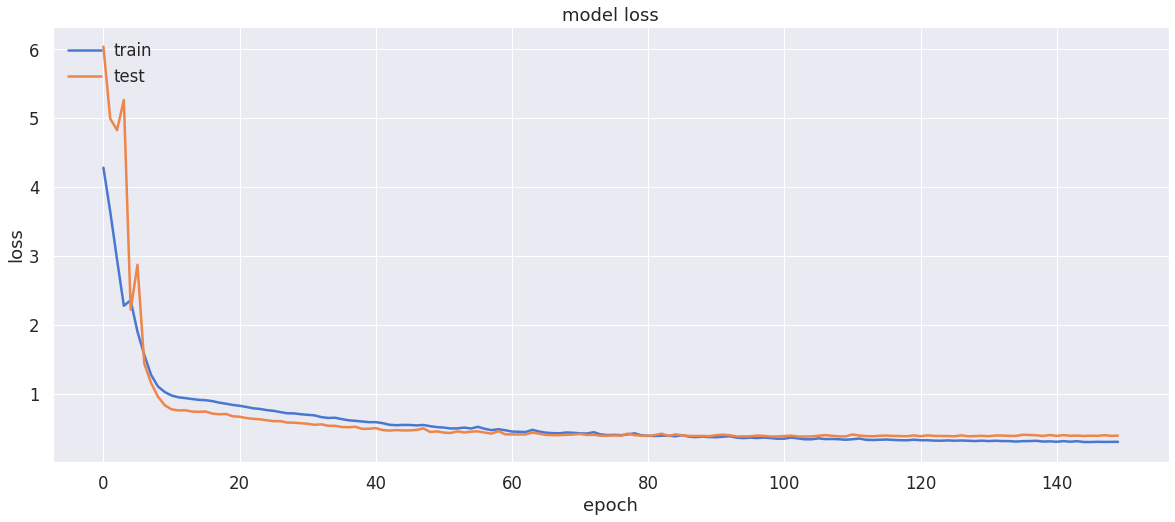

In [16]:
import cf_models as cm

n_users, n_items = X.shape

fold_number = 0
test_size = 0.1

policy_threshold = 'fmax'
# conf_measure = 'brier' 
n_factors = 100
# alpha = 100

lr = 0.001 
batch_size = 64
epochs = 150    # NOTE that this is typically is not equal to the epochs required for the polarity model

loss_fn = tf.keras.losses.MeanSquaredError()  # Options: cm.confidence_weighted_loss, cm.c_squared_loss, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), ...
cf_model = cm.get_cfnet_compiled(n_users, n_items, n_factors, loss=loss_fn, lr=lr)
# cf_model = cm.get_cfnet_approximating_labels(n_users, n_items, n_factors)

# Configure `target_type` (Options: 'generic', 'rating', 'label')
# 1. Choose 'label' if the BCE loss is used (because the CF model in this case attempts to approximates the label encoded in 0 and 1)
# 2. Choose 'rating' if MSE is used (because the CF model in this case approximates the rating, which is a regression problem)
# 3. Choose 'generic' for customized loss function with potentially more complex labeling information where "y_true" is a matrix 
# 
# Note that you are unlikely need to configure `target_type` because cf_models module has a method that will determine this for you automatically
# target_type = 'label'

cf_model = cm.training_with_reliability(
                                 input_model=(cf_model, loss_fn),  # [todo] incorperate polarity model
                                 input_data={'X': np.hstack([R, T]),
                                             'P': Pf_seq2seq, 
                                             'C': C, 
                                             'U': U, 
                                             'L_train': L_train}, 

                                # SGD optimization parameters
                                test_size = test_size,
                                epochs = epochs, 
                                batch_size=batch_size, 

                                # CF hyperparameters
                                # n_factors=n_factors, # this is factored into model definition
                                policy_threshold=policy_threshold,
                                # target_type=target_type,
        
                                fold_number=fold_number) 

In [17]:
analyzer = cm.analyze_reconstruction(cf_model, 
                                     X=(R, T),
                                     L=(L_train, lh_seq2seq), # Note that estimated labels on T (lh_seq2seq) is only optional; won't be used 
                                     Pc=Pf_seq2seq, p_threshold=p_threshold, policy_threshold=policy_threshold)
highlight("Reestimate the entire rating matrix (X) with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=False)
highlight("Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=True, verbose=2)

Reestimate the entire rating matrix (X) with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 36.45880080463653
[info] From T to Th, delta(Frobenius norm)= 19.440164046335546
[info] How different are lh and lh_new? 0.5368
[result] Majority vote: F1 score with the original T:  0.19441069258809235
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.19917012448132781
[result] Majority vote: F1 score with re-estimated Th: 0.20833333333333334

[result] Stacking: F1 score with the original T:  0.11188811188811189
[result] Stacking: F1 score with re-estimated Th: 0.22831050228310504

[result] Best settings (complete): lh2_maxvote_pth_adjusted, score: 0.20833333333333334

Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 35.5999230413623
[info] From T to Th, delta(Frobenius norm)= 16.815214343984316
[info] How different are lh and lh_new? 0.5048
[result] Maj